In [1]:
# Section 1: Setup and Data Loading

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # We'll use a time-series split later
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Configure plots for better visualization
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style
%matplotlib inline

# --- Data Loading ---
ticker_symbol = "BTC-USD"
start_date = "2018-01-01"
# Explicitly set end_date to today to avoid future data
actual_end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

try:
    btc_data_raw = yf.download(ticker_symbol, start=start_date, end=actual_end_date)
    print(f"Successfully downloaded data for {ticker_symbol} up to {actual_end_date}")

    # --- Flatten MultiIndex columns if present ---
    # yfinance sometimes returns a multi-index dataframe, especially if 'group_by="ticker"' was implied.
    # For a single ticker, we can simplify the column names.
    if isinstance(btc_data_raw.columns, pd.MultiIndex):
        print("Flattening MultiIndex columns.")
        # If columns are like ('Close', 'BTC-USD'), take the first level
        btc_data = btc_data_raw.copy()
        btc_data.columns = btc_data.columns.droplevel(1) # Drop the ticker level
    else:
        btc_data = btc_data_raw.copy()

    # Ensure data does not extend beyond today (important if yfinance pulls unexpected future dates)
    btc_data = btc_data[btc_data.index <= pd.Timestamp.today().normalize()]


    print("\n--- First 5 rows of the dataset (after potential flattening) ---")
    print(btc_data.head())

    print("\n--- Last 5 rows of the dataset (after potential flattening and date cap) ---")
    print(btc_data.tail()) # This should now show data up to the actual 'today'

    print("\n--- Dataset Information ---")
    btc_data.info()

    print("\n--- Descriptive Statistics ---")
    print(btc_data.describe())

except Exception as e:
    print(f"Error downloading or processing data: {e}")
    btc_data = pd.DataFrame()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for BTC-USD up to 2025-05-28
Flattening MultiIndex columns.

--- First 5 rows of the dataset (after potential flattening) ---
Price              Close          High           Low          Open  \
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  

--- Last 5 rows of the dataset (after potential flattening and date cap) ---
Price               Close           High            Low           Open  \
Date                

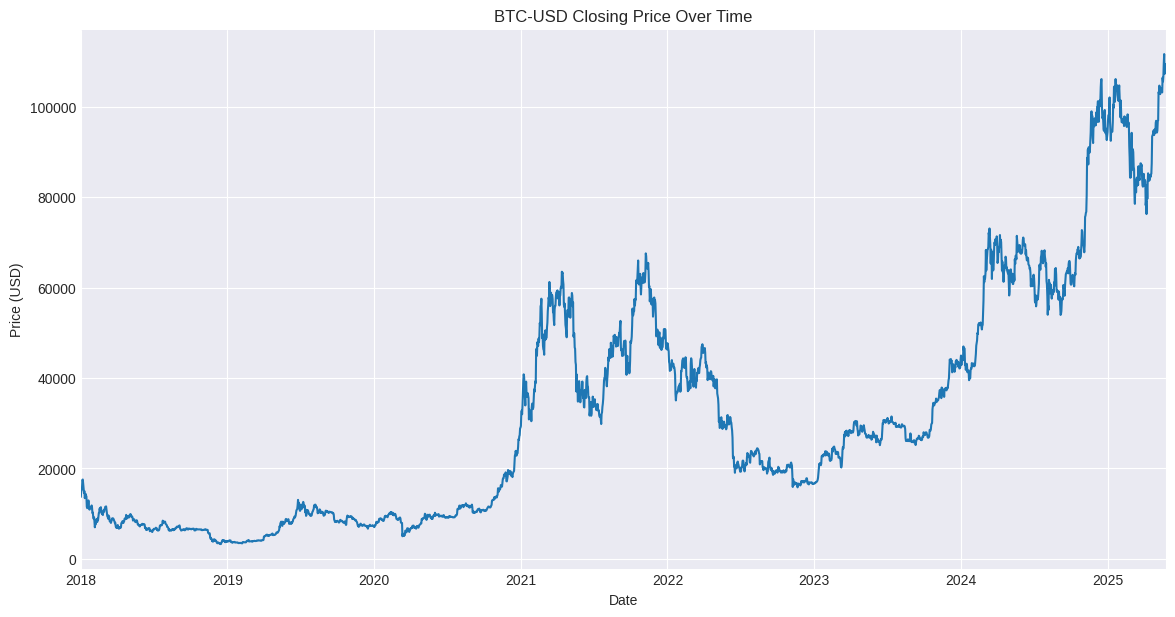


--- Missing Values Check ---
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

No missing values found in the dataset.


In [2]:
# Section 2: Exploratory Data Analysis (EDA) & Preprocessing (Initial)

if not btc_data.empty:
    # Plot the closing price
    plt.figure(figsize=(14, 7))
    btc_data['Close'].plot(title=f'{ticker_symbol} Closing Price Over Time')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.show()

    # --- Check for Missing Values ---
    print("\n--- Missing Values Check ---")
    missing_values = btc_data.isnull().sum()
    print(missing_values)
    if missing_values.sum() == 0:
        print("\nNo missing values found in the dataset.")
    else:
        print("\nMissing values found. Consider handling them.")
else:
    print("Skipping EDA as no data was loaded.")

In [3]:
# Section 3: Feature Engineering

if not btc_data.empty:
    print("\n--- Starting Feature Engineering ---")
    # Make a copy to avoid SettingWithCopyWarning and keep original data intact
    data_fe = btc_data.copy()

    # 1. Create the Target Variable: 'Price_Up'
    # Predict if the *next day's* closing price will be higher than the *current day's* closing price.
    data_fe['Future_Close'] = data_fe['Close'].shift(-1)
    data_fe['Price_Up'] = (data_fe['Future_Close'] > data_fe['Close']).astype(int)

    # Display the target variable creation
    print("\n--- Target Variable ('Price_Up') created ---")
    print(data_fe[['Close', 'Future_Close', 'Price_Up']].head(10))
    print(data_fe[['Close', 'Future_Close', 'Price_Up']].tail(10)) # Note the last row will have NaN for Future_Close and Price_Up

    # 2. Lagged Features
    # Use past price and volume data as features.
    lags = [1, 3, 7, 14] # Lag periods in days
    for lag in lags:
        data_fe[f'Close_Lag_{lag}'] = data_fe['Close'].shift(lag)
        data_fe[f'Volume_Lag_{lag}'] = data_fe['Volume'].shift(lag)

    print("\n--- Lagged features created ---")
    print(data_fe[['Close'] + [f'Close_Lag_{lag}' for lag in lags]].head(max(lags) + 2))

    # 3. Moving Average (MA) Features
    # Simple Moving Averages for Close price and Volume
    ma_windows = [7, 14, 30] # Moving average windows in days
    for window in ma_windows:
        data_fe[f'MA_Close_{window}'] = data_fe['Close'].rolling(window=window).mean()
        data_fe[f'MA_Volume_{window}'] = data_fe['Volume'].rolling(window=window).mean()

    print("\n--- Moving Average features created ---")
    print(data_fe[['Close'] + [f'MA_Close_{window}' for window in ma_windows]].head(max(ma_windows) + 2))

    # 4. Daily Return (Percentage Change)
    # (Current Close - Previous Close) / Previous Close
    data_fe['Daily_Return'] = data_fe['Close'].pct_change() * 100 # as percentage

    # 5. Volatility (Rolling Standard Deviation of Close Price)
    volatility_windows = [7, 30]
    for window in volatility_windows:
        data_fe[f'Volatility_{window}'] = data_fe['Close'].rolling(window=window).std()

    print("\n--- Daily Return & Volatility features created ---")
    print(data_fe[['Close', 'Daily_Return'] + [f'Volatility_{window}' for window in volatility_windows]].head(max(volatility_windows if volatility_windows else [0]) + 2))


    # --- Handle NaN values created by shifts and rolling windows ---
    # The target variable 'Price_Up' will have a NaN for the very last row because there's no 'next day' to compare.
    # Lagged features and MAs will have NaNs at the beginning.
    # We should drop rows with any NaN values in features or target before training.

    print(f"\nShape before dropping NaNs: {data_fe.shape}")
    # The last row will have NaN for 'Future_Close' and 'Price_Up' as there's no next day.
    # We must drop this row. Other NaNs come from lags/rolling windows at the start.
    data_fe.dropna(inplace=True)
    print(f"Shape after dropping NaNs: {data_fe.shape}")

    # Display the first few rows of the dataset with all engineered features (after NaN drop)
    if not data_fe.empty:
        print("\n--- First 5 rows of dataset with all features (after NaN drop) ---")
        print(data_fe.head())
        print("\n--- Last 5 rows of dataset with all features (after NaN drop) ---")
        print(data_fe.tail()) # Check if 'Future_Close' and 'Price_Up' are valid
        print("\n--- Columns in the feature-engineered dataset ---")
        print(data_fe.columns)
    else:
        print("Dataset is empty after dropping NaNs. Check lag/window periods relative to dataset size.")

else:
    print("Skipping Feature Engineering as no data was loaded.")


--- Starting Feature Engineering ---

--- Target Variable ('Price_Up') created ---
Price              Close  Future_Close  Price_Up
Date                                            
2018-01-01  13657.200195  14982.099609         1
2018-01-02  14982.099609  15201.000000         1
2018-01-03  15201.000000  15599.200195         1
2018-01-04  15599.200195  17429.500000         1
2018-01-05  17429.500000  17527.000000         1
2018-01-06  17527.000000  16477.599609         0
2018-01-07  16477.599609  15170.099609         0
2018-01-08  15170.099609  14595.400391         0
2018-01-09  14595.400391  14973.299805         1
2018-01-10  14973.299805  13405.799805         0
Price               Close   Future_Close  Price_Up
Date                                              
2025-05-17  103191.085938  106446.007812         1
2025-05-18  106446.007812  105606.179688         0
2025-05-19  105606.179688  106791.085938         1
2025-05-20  106791.085938  109678.078125         1
2025-05-21  109678.078

In [4]:
# Section 4: Model Training

if not data_fe.empty:
    print("\n--- Starting Model Training ---")

    # 1. Define Features (X) and Target (y)
    # Features: All columns except 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close' (if present), 'Future_Close', and 'Price_Up'
    # 'Adj Close' is often the same as 'Close' for cryptos from yfinance, but good to exclude if it exists.
    # 'Open', 'High', 'Low', 'Close', 'Volume' are current day's raw values,
    # we are using their lagged/transformed versions.

    potential_features = data_fe.drop(columns=[
        'Open', 'High', 'Low', 'Close', 'Volume', # Original raw values for current day
        'Future_Close', 'Price_Up' # Target and its source
    ])

    # Ensure all feature columns are numeric and have no new NaNs (should be fine after previous dropna)
    # For safety, though dropna should have handled it:
    # potential_features = potential_features.fillna(potential_features.mean()) # Or another strategy

    X = potential_features
    y = data_fe['Price_Up']

    print(f"\nShape of X (features): {X.shape}")
    print(f"Shape of y (target): {y.shape}")
    print(f"\nFeatures being used: {X.columns.tolist()}")

    # 2. Time-Series Train-Test Split
    # We must split the data chronologically to avoid look-ahead bias.
    # For example, use 80% for training and 20% for testing.
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)

    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(f"\nTraining set size: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"Testing set size: X_test {X_test.shape}, y_test {y_test.shape}")
    print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
    print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

    # 3. Feature Scaling (StandardScaler)
    # Important for some algorithms like Logistic Regression, SVMs, Neural Networks
    # For tree-based models, it's not strictly necessary but doesn't hurt.
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Use transform only, no re-fitting on test data

    # Convert scaled arrays back to DataFrames for easier inspection if needed (optional)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("\n--- Feature scaling applied ---")
    # print("X_train_scaled head:\n", X_train_scaled_df.head())


    # 4. Train a Baseline Model (Logistic Regression)
    model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # liblinear is good for smaller datasets

    # Train the model on the scaled training data
    model.fit(X_train_scaled, y_train)

    print(f"\n--- Model training complete ---")
    print(f"Model: {model}")

else:
    print("Skipping Model Training as data_fe is empty.")


--- Starting Model Training ---

Shape of X (features): (2673, 17)
Shape of y (target): (2673,)

Features being used: ['Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_7', 'Volume_Lag_7', 'Close_Lag_14', 'Volume_Lag_14', 'MA_Close_7', 'MA_Volume_7', 'MA_Close_14', 'MA_Volume_14', 'MA_Close_30', 'MA_Volume_30', 'Daily_Return', 'Volatility_7', 'Volatility_30']

Training set size: X_train (2138, 17), y_train (2138,)
Testing set size: X_test (535, 17), y_test (535,)
Training data from 2018-01-30 00:00:00 to 2023-12-07 00:00:00
Testing data from 2023-12-08 00:00:00 to 2025-05-25 00:00:00

--- Feature scaling applied ---

--- Model training complete ---
Model: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')



--- Starting Model Evaluation ---

Accuracy: 0.4991

Test set 'Price_Up' distribution:
Price_Up
1    0.521495
0    0.478505
Name: proportion, dtype: float64

--- Confusion Matrix ---
[[241  15]
 [253  26]]


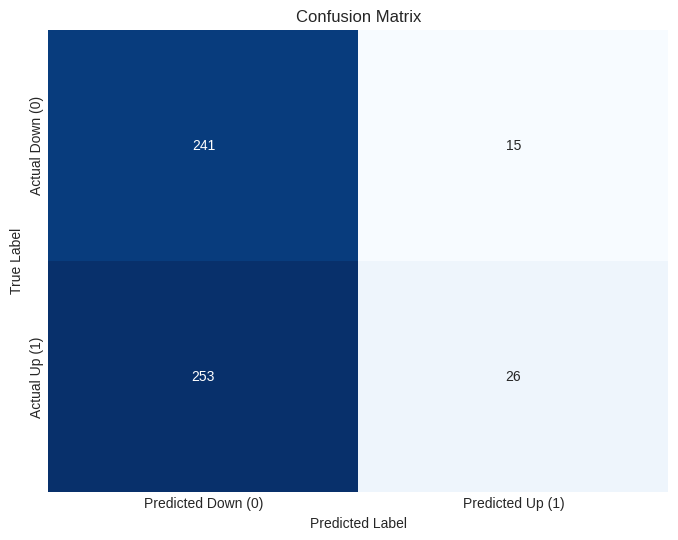


--- Classification Report ---
                precision    recall  f1-score   support

Price Down (0)       0.49      0.94      0.64       256
  Price Up (1)       0.63      0.09      0.16       279

      accuracy                           0.50       535
     macro avg       0.56      0.52      0.40       535
  weighted avg       0.56      0.50      0.39       535


ROC AUC Score: 0.5320


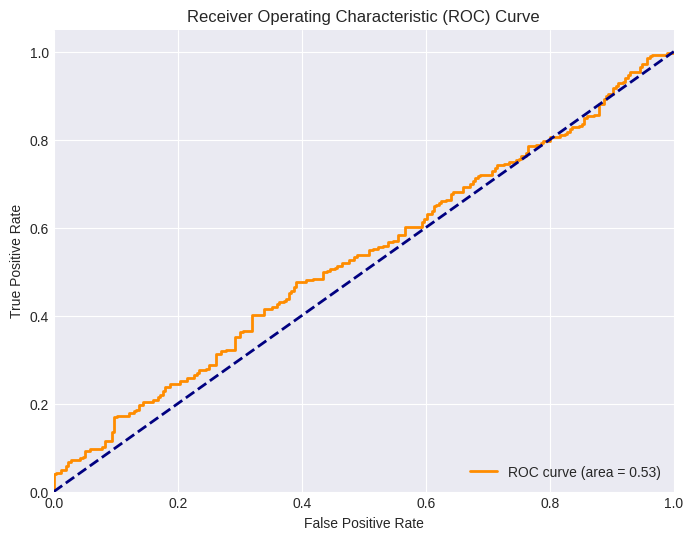

In [5]:
# Section 5: Model Evaluation

if 'model' in globals() and not X_test_scaled_df.empty: # Check if model exists and test data is available
    print("\n--- Starting Model Evaluation ---")

    # 1. Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class (Price_Up = 1)

    # 2. Evaluate the model
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Check the balance of the target variable in the test set
    print(f"\nTest set 'Price_Up' distribution:\n{y_test.value_counts(normalize=True)}")
    # If the classes are imbalanced, accuracy alone can be misleading.
    # A "naive" model predicting the majority class all the time might have high accuracy.

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plotting the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Down (0)', 'Predicted Up (1)'],
                yticklabels=['Actual Down (0)', 'Actual Up (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Price Down (0)', 'Price Up (1)']))

    # ROC AUC Score
    # Requires probabilities of the positive class
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC Score: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal for random chance
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    except ValueError as e:
        print(f"\nCould not calculate ROC AUC or plot ROC curve: {e}")
        print("This can happen if the model predicts only one class in the test set.")


    # 4. Discussion (to be filled in the README, but think about it here)
    # - How does the accuracy compare to a naive guess (e.g., always predicting the majority class)?
    # - What do precision and recall tell you about the model's ability to predict 'up' movements vs. 'down' movements?
    # - Is the ROC AUC score significantly better than 0.5 (random guessing)?
    # - Financial markets are notoriously hard to predict. Don't expect extremely high scores with a simple model.
    #   Scores slightly above 0.5 (for ROC AUC or accuracy on a balanced set) can be considered a starting point.

else:
    print("Skipping Model Evaluation as the model or test data is not available.")


--- Starting Model Interpretability ---

--- Feature Coefficients (Importance) ---
          Feature  Coefficient
10    MA_Close_14     0.280590
4     Close_Lag_7    -0.262909
11   MA_Volume_14     0.231475
3    Volume_Lag_3    -0.179214
0     Close_Lag_1    -0.135390
14   Daily_Return    -0.124803
5    Volume_Lag_7    -0.108647
15   Volatility_7     0.102238
13   MA_Volume_30     0.079714
1    Volume_Lag_1    -0.068103
6    Close_Lag_14    -0.046702
12    MA_Close_30     0.036718
2     Close_Lag_3    -0.020602
9     MA_Volume_7     0.018598
7   Volume_Lag_14    -0.015013
8      MA_Close_7    -0.008350
16  Volatility_30     0.000531


<ipython-input-6-0692ca5e7fe4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette='viridis') # Top 15 features


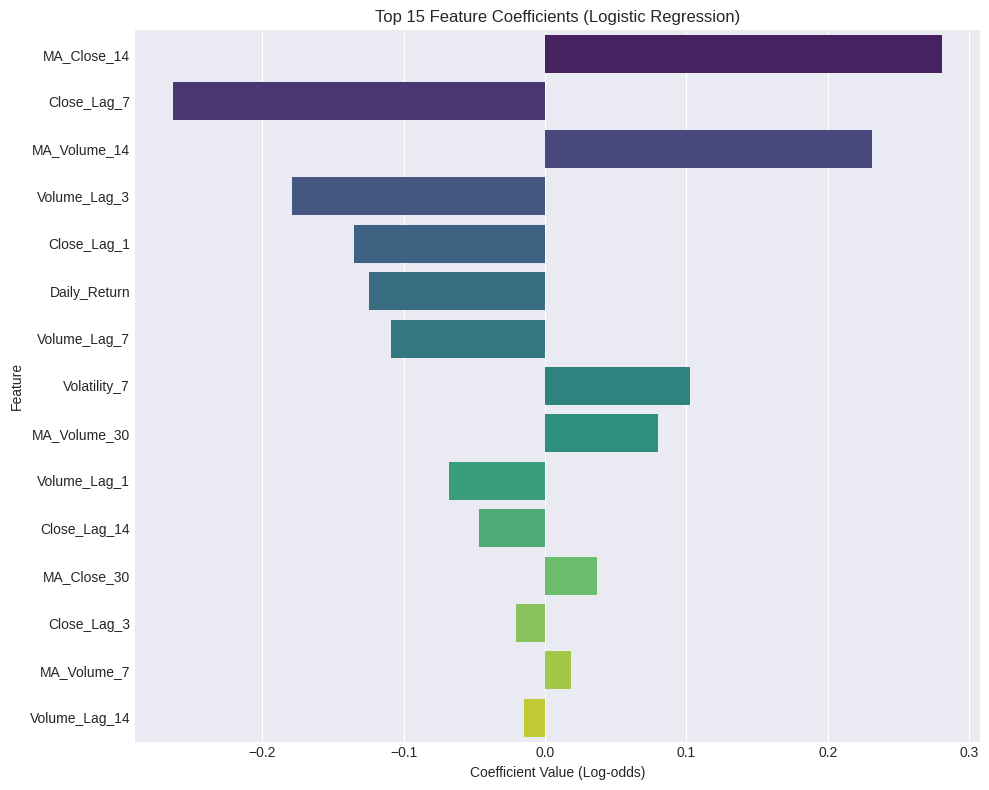


Interpretation of Coefficients:
- Positive coefficient: An increase in this feature's value increases the log-odds (and thus probability) of Price_Up = 1.
- Negative coefficient: An increase in this feature's value decreases the log-odds (and thus probability) of Price_Up = 1.
- The magnitude indicates the strength of the influence (on the log-odds scale).
Note: Coefficients are based on scaled data. Interpretation is about the effect of a one standard deviation change in the original feature.


In [6]:
# Section 6: Interpretability (Feature Importance for Logistic Regression)

if 'model' in globals() and 'X_train' in globals(): # Check if model and X_train (for column names) exist
    print("\n--- Starting Model Interpretability ---")

    try:
        # Get feature importance (coefficients for Logistic Regression)
        coefficients = model.coef_[0] # For binary classification, coef_ is a 2D array with one row

        # Create a DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns, # Use original column names before scaling
            'Coefficient': coefficients
        })

        # Sort by absolute value of coefficient to see most influential features
        feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
        feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

        print("\n--- Feature Coefficients (Importance) ---")
        print(feature_importance_df[['Feature', 'Coefficient']].to_string()) # .to_string() to print all rows

        # Plotting feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette='viridis') # Top 15 features
        plt.title('Top 15 Feature Coefficients (Logistic Regression)')
        plt.xlabel('Coefficient Value (Log-odds)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        print("\nInterpretation of Coefficients:")
        print("- Positive coefficient: An increase in this feature's value increases the log-odds (and thus probability) of Price_Up = 1.")
        print("- Negative coefficient: An increase in this feature's value decreases the log-odds (and thus probability) of Price_Up = 1.")
        print("- The magnitude indicates the strength of the influence (on the log-odds scale).")
        print("Note: Coefficients are based on scaled data. Interpretation is about the effect of a one standard deviation change in the original feature.")


    except Exception as e:
        print(f"Could not retrieve or display feature importance: {e}")
else:
    print("Skipping Model Interpretability as the model or X_train is not available.")